In [ ]:
from PIL import Image
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import math
from google.colab.patches import cv2_imshow

# 1.0 Basic Image Operations

## 1.1 Combining Two Images

a. Read in two large (> 256 x 256) images, A and B into your Colab notebook (see sample Colab notebook that was shared with the class earlier).

Image A shape:  (480, 640, 3)


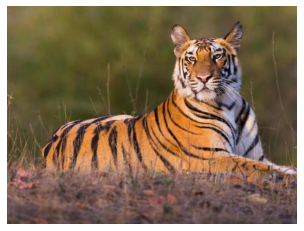

In [ ]:
im_A = Image.open('tiger.jpeg')
im_A = np.array(im_A)
print("Image A shape: ", im_A.shape)
plt.imshow(im_A); plt.axis(False);

Image B shape:  (480, 640, 3)


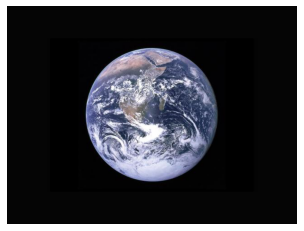

In [ ]:
im_B = Image.open('earth.jpeg')
im_B = np.array(im_B)
print("Image B shape: ", im_B.shape)
plt.imshow(im_B); plt.axis(False);

b. Resize A to 256x256 and crop B at the center to 256x256.

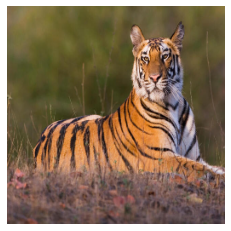

In [ ]:
im_A_256 = cv2.resize(im_A, (256, 256))
plt.imshow(im_A_256); plt.axis(False);

New shape for image B:  (256, 256, 3)


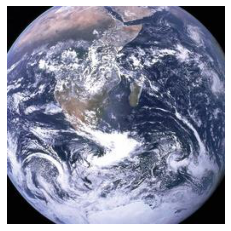

In [ ]:
height, width, channel = im_B.shape
top = int(width/2 - 128)
left = int(height/2 - 128)
im_B_crop = im_B[left:left+256, top:top+256, :]
print("New shape for image B: ", im_B_crop.shape)
plt.imshow(im_B_crop); plt.axis(False);

c. Create a new image C such that the left half of C is the left half of A and the right half of C is the right half of B.

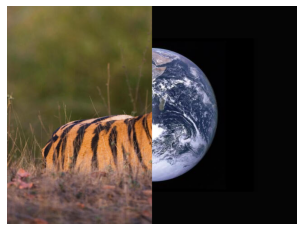

In [ ]:
left_half_A = im_A[:,:width//2]
right_half_B = im_B[:,width//2:]
im_C = np.concatenate((left_half_A, right_half_B), axis=1)
plt.imshow(im_C); plt.axis(False);

d. Using a loop, create a new image D such that every odd numbered row is the corresponding row from A and every even row is the corresponding row from B.

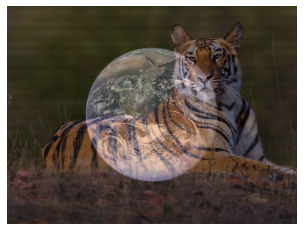

In [ ]:
im_D = np.zeros((height, width, 3), dtype=im_A.dtype)

for i in range(height):
    if i % 2 == 0:
        im_D[i, :] = im_B[i, :]
    else:
        im_D[i, :] = im_A[i, :]

plt.imshow(im_D); plt.axis(False);

e. Accomplish the same task in part d without using a loop. Describe your process.

My process: I using numpy's advanced indexing and broadcasting let even_indices arrays containing the indices of even rows, and another odd_indices arrays containing the indices of odd rows, simply using "%2" operator. 
This would be faster than using a loop, because it takes advantage of numpy's vectorized operations.

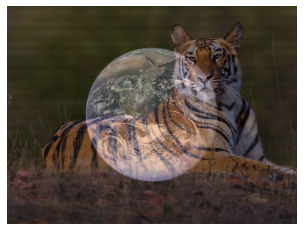

In [ ]:
height, width = im_A.shape[:2]
# Create an array row_indices that contains all the row indices of the image.
row_indices = np.arange(height)
# Create an array even_indices that contains all even indices from row_indices.
even_indices = row_indices[row_indices %2 == 0]
# Create an array odd_indices that contains all odd indices from row_indices.
odd_indices = row_indices[row_indices %2 != 0]
# Initialize a zero-filled image im_D with the same height, width, and data type as im_A
im_D = np.zeros((height, width, 3), dtype=im_A.dtype)
# Set the even row pixels of im_D equal to the even row pixels of im_B.
im_D[even_indices] = im_B[even_indices]
# Set the odd row pixels of im_D equal to the odd row pixels of im_A.
im_D[odd_indices] = im_A[odd_indices]

plt.imshow(im_D); plt.axis(False);

## 1.2 Color Spaces

a. Download the peppers image from this link. Return a binary image (only 0s and 1s), with 1s corresponding to only the yellow peppers. Do this by setting a minimum and maximum threshold value on pixel values in the R,G,B channels. Note that you won’t be able to perfectly capture the yellow peppers, but give your best shot!

Image A shape:  (384, 512, 3)


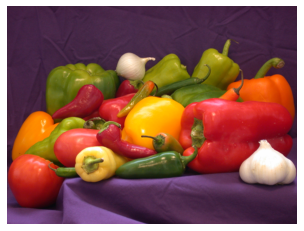

In [ ]:
im = Image.open('peppers_BlueHills.png')
im = np.array(im)
print("Image A shape: ", im.shape)
plt.imshow(im); plt.axis(False);

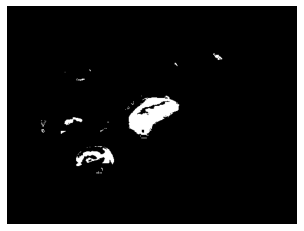

In [ ]:
img = cv2.imread('peppers_BlueHills.png')
img_RGB = np.copy(img)

# Threshold the image to get only yellow colors
img_RGB[img_RGB[:,:,0] > 125] = 0 # Blue channel
img_RGB[img_RGB[:,:,1] < 180] = 0 # Green channel
img_RGB[img_RGB[:,:,2] < 180] = 0 # Red channel
img_gray = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)

# Apply Otsu thresholding to the grayscale image to get a binary image
_, binary_img = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(binary_img, cmap="gray"); plt.axis(False);

b. While RGB is the most common color space for images, it is not the only one. For example, one popular color space is HSV (Hue-Saturation-Value). Hue encodes color, value encodes lightness/darkness, and saturation encodes the intensity of the color. For a visual, see Fig. 1 of this wiki article. Convert the image to the HSV color space using OpenCV’s cvtColor() function, and try to perform the same task by setting a threshold in the Hue channel.

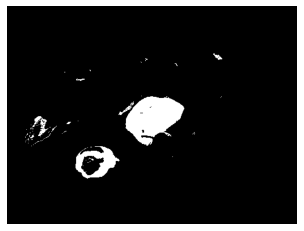

In [ ]:
# Convert the image to the HSV color space
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define the range of yellow color in HSV
lower_yellow = (17, 100, 200)
upper_yellow = (30, 255, 255)

# Threshold the image to get only yellow colors
img_thresholded = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
plt.imshow(img_thresholded, cmap="gray"); plt.axis(False);

# 2.0 2D Geometric Transforms

## 2.1 Write functions to produce transformation matrices
Write separate functions that output the 3 x 3 transformation matrices for the following transforms: translation, rotation, similarity (translation, rotation, and scale), and affine. The functions should take as input the following arguments:

1. Translation: horizontal and vertical displacements

In [ ]:
# horizontal translation by 'tx' units and vertical translation by 'ty' units:
def translate(tx, ty):
    return [[1, 0, tx],
         [0, 1, ty],
         [0, 0, 1]]

2. Rotation: angle

In [ ]:
def rotate(angle):
    angle = angle * np.pi / 180
    c, s = np.cos(angle), np.sin(angle)
    return [[c, s, 0], 
         [-s, c, 0], 
         [0, 0, 1]]

3. Similarity: angle, horizontal/vertical displacements, and scale factor (assume equal
scaling for horizontal and vertical dimensions)

In [ ]:
def similarity(angle, tx, ty, scale):
    scaling = np.array([[scale, 0, 0], 
               [0, scale, 0], 
               [0, 0, 1]])
    result = np.array([[0, 0, 0], 
               [0, 0, 0], 
               [0, 0, 0]])
    result = np.dot(translate(tx, ty), rotate(angle))
    result = np.dot(result, scaling)
    return result

4. Affine: 6 parameters

In [ ]:
# angle, horizontal/vertical displacements, scale and shearing horizontal/vertical dimensions factor (assume equal scaling for horizontal and vertical dimensions)
def affine(angle, tx, ty, scale, ax, ay):
    scaling = np.array([[scale, 0, 0], 
               [0, scale, 0], 
               [0, 0, 1]])
    shearing = np.array([[1, ax, 0], 
                [ay, 1, 0], 
                [0, 0, 1]])
    result = np.array([[0, 0, 0], 
               [0, 0, 0], 
               [0, 0, 0]])
    result = np.dot(translate(tx, ty), rotate(angle))
    result = np.dot(result, scaling)
    result = np.dot(result, shearing)
    return result

## 2.2 Write a function that warps an image with a given transformation matrix
Next, write a function imwarp(I, T) that warps image I with transformation matrix T. The function should produce an output image of the same size as I. See Fig. 1 for an example of a warp induced by a rotation transformation matrix. Make the origin of the coordinate system correspond to the CENTER of the image, not the top-left corner. This will result in more intuitive results, such as how the image is rotated around its center in Fig. 1.

**Hint 1**: Consider the transformation matrix T to describe the mapping from each pixel in the output image back to the original image. By defining T in this way, you can account for each output pixel in the warp, resulting in no ‘holes’ in the output image (see Lec. 03 slides).

**Hint 2:** What happens when the transformation matrix maps an output pixel to a non-integer location in the input image? You will need to perform bilinear interpolation to handle this correctly (see Lec. 03 slides).

**Hint 3:** You may find NumPy’s meshgrid function useful to generate all pixel coordinates at once, without a loop.

Image dog shape:  (570, 714, 4)


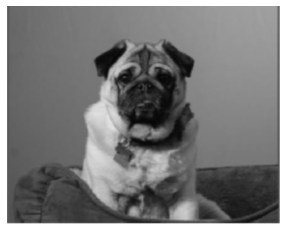

In [ ]:
img = Image.open('dog.png')
img = np.array(img)
print("Image dog shape: ", img.shape)
plt.imshow(img); plt.axis(False);

In [ ]:
def bilinear_interpolation(img, x, y):
  # Find the 4 nearest pixels to the point (x, y)
  x1 = int(x)
  x2 = x1 + 1
  y1 = int(y)
  y2 = y1 + 1

  # Check if the point is out of the image boundary
  if x1 < 0 or y1 < 0 or x2 >= img.shape[1] or y2 >= img.shape[0]:
      return 0
  else:
      # Get the pixel values of the 4 nearest pixels
      f_11 = img[y1][x1]
      f_12 = img[y1][x2]
      f_21 = img[y2][x1]
      f_22 = img[y2][x2]
      # Calculate the weight of each pixel
      w1 = (x2 - x) * (y2 - y)
      w2 = (x - x1) * (y2 - y)
      w3 = (x2 - x) * (y - y1)
      w4 = (x - x1) * (y - y1)
      # Interpolate the pixel value using the weights
      return w1 * f_11 + w2 * f_12 + w3 * f_21 + w4 * f_22

def imwarp(I, T):
  rows, cols = I.shape[:2]
  # Create an empty output image
  output_image = np.zeros((rows, cols, 3))
  # Define the center of the image
  center = (cols/2, rows/2)
  # Calculate the inverse transformation matrix
  T_inv = np.linalg.inv(T)

  # Iterate through all pixels in the output image
  for i in range(rows):
    for j in range(cols):
      # Shift the coordinates to the center of the image
      coord = np.array([j-center[0], i-center[1], 1])
      # Transform the coordinates using the inverse transformation matrix
      coord = np.dot(T_inv, coord)
      # Shift the coordinates back to the top-left corner of the image
      x, y = coord[0] + center[0], coord[1] + center[1]
      # Interpolate the pixel value
      output_image[i][j] = bilinear_interpolation(I, x, y)
  output_image = np.array(output_image,np.uint8)
    
  return output_image

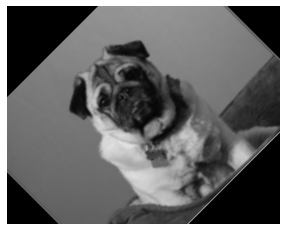

In [ ]:
img = cv2.imread("dog.png")
# apply rotate transformation function
transformation_matrix = rotate(45)
output_image = imwarp(img, transformation_matrix)
# Show the output image and convert from BGR to RGB
plt.imshow(output_image[..., ::-1]); plt.axis(False);

## 2.3 Demonstrate your warping code on two color images of your choice
For each of the two images, show 2-3 transformations of each type (translation, rotation, similarity, affine) in your report.

<Figure size 432x288 with 0 Axes>

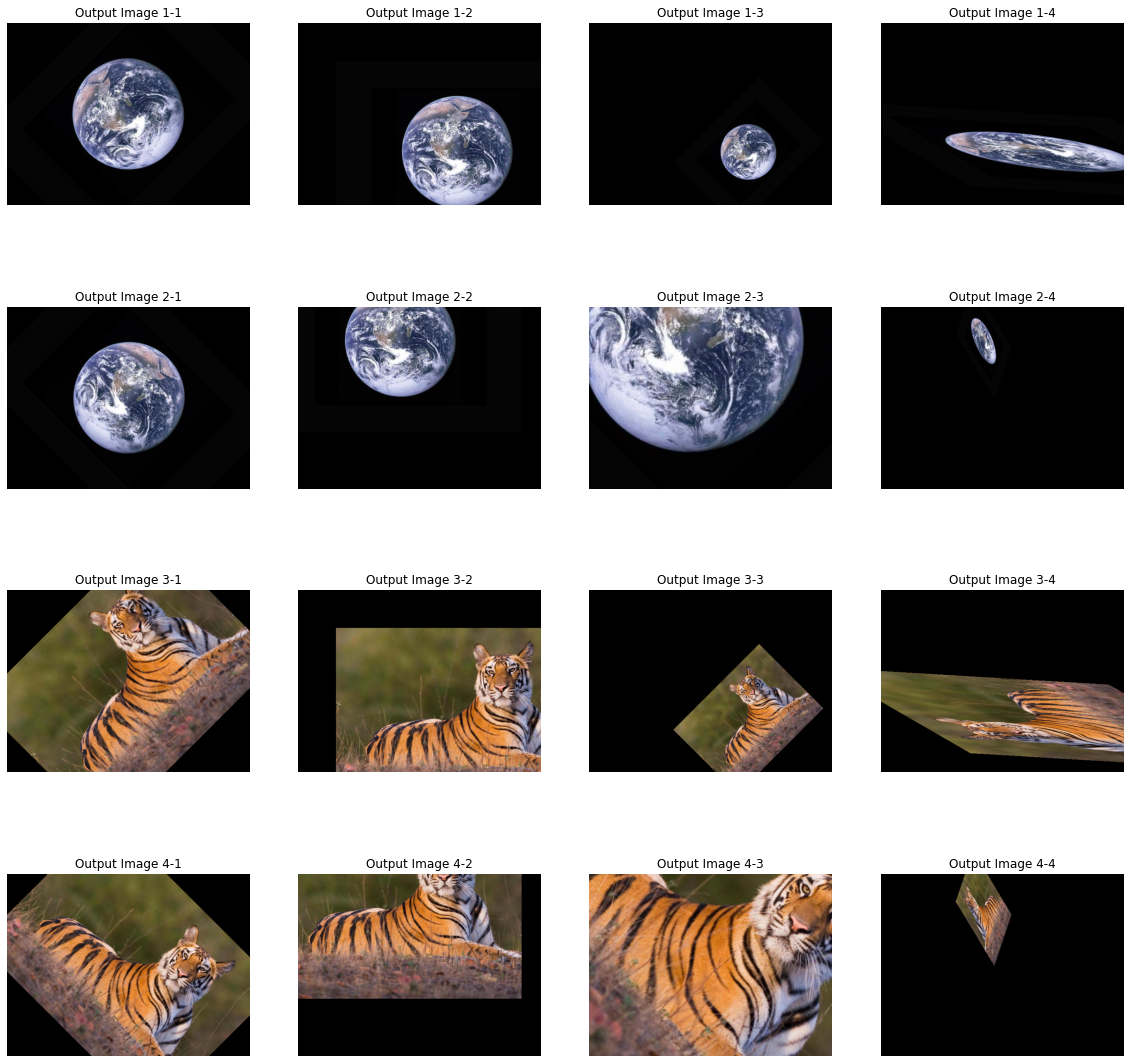

In [ ]:
img = cv2.imread("earth.jpeg")
image1 = imwarp(img, rotate(45)) # rotate(angle)
image2 = imwarp(img, translate(100, 100)) # translate(x-axis shift, y-axis shift)
image3 = imwarp(img, similarity(45, 100, 100, 0.5)) # similarity(angle, x-axis shift, y-axis shift, scale)
image4 = imwarp(img, affine(15, 100, 100, 0.5, 3, 1)) # affine(angle, x-axis shift, y-axis shift, scale, x shearing, y shearing)

image5 = imwarp(img, rotate(-45))
image6 = imwarp(img, translate(-50, -150))
image7 = imwarp(img, similarity(-45, -50, -150, 2))
image8 = imwarp(img, affine(-45, -50, -150, 0.1, 4, 2))

img = cv2.imread("tiger.jpeg")
image9 = imwarp(img, rotate(45))
image10 = imwarp(img, translate(100, 100))
image11 = imwarp(img, similarity(45, 100, 100, 0.5))
image12 = imwarp(img, affine(15, 100, 100, 0.5, 3, 1))

image13 = imwarp(img, rotate(-45))
image14 = imwarp(img, translate(-50, -150))
image15 = imwarp(img, similarity(-45, -50, -150, 2))
image16 = imwarp(img, affine(-45, -50, -150, 0.1, 4, 2))

plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(20, 20)) 
output_images = [image1, image2, image3, image4,
                 image5, image6, image7, image8,
                 image9, image10, image11, image12,
                 image13, image14, image15, image16]
index = 0
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(output_images[index][..., ::-1])
        ax[i][j].axis('off')
        ax[i][j].set_title("Output Image {}-{}".format(i+1, j+1))
        index += 1

# 3.0 Cameras (15 points)

## 3.1 Camera Matrix Computation

a. Calculate the camera intrinsic matrix K, extrinsic matrix E, and full rank 4 ⨉ 4 projection matrix P = KE for the following scenario with a pinhole camera:

- The camera is rotated 90 degrees around the x-axis, and is located at (1, 0, 2)^𝑇.
  
- The focal lengths 𝑓𝑥, 𝑓𝑦 are 100.

- The principal point (𝑐𝑥, 𝑐𝑦)^𝑇 is (25, 25).

In [ ]:
# Intrinsic parameters of the camera
f_x = 100 # focal length in x-direction
f_y = 100 # focal length in y-direction
c_x = 25  # x-coordinate of the principal point
c_y = 25  # y-coordinate of the principal point

# Camera intrinsic matrix K
K = np.array([[f_x, 0, c_x], 
        [0, f_y, c_y], 
        [0, 0, 1]])

# Rotation matrix R around x-axis with 90-degree angle
c, s = np.cos(np.pi/2), np.sin(np.pi/2)
R = np.array([[1, 0, 0], 
        [0, c, -s], 
        [0, s, c]])

# Translation matrix I*-T
IT = np.array([[1, 0, 0, -1], 
         [0, 1, 0, 0], 
         [0, 0, 1, -2]])

# Calculate extrinsic matrix E
E = np.dot(R, IT)

# Projection matrix
P = np.dot(K, E)

# Set precision of printed values and suppress small values
np.set_printoptions(precision=2, suppress=True)
print(P)

[[ 100.   25.    0. -100.]
 [   0.   25. -100.  200.]
 [   0.    1.    0.   -0.]]


# 4.0 Relighting
In this problem, you will perform a simple version of image relighting, the task of changing the lighting on a scene. To do this experiment, you will need two light sources (such as ceiling lights, floor lamps, flashlights etc.) and a couple of scene objects. Set up a static scene similar to the one shown in Fig. 2 (the light sources do not have to be seen in the frame, but try to have them illuminating the scene at two different angles), and a camera such that it is stationary throughout the experiment (cell phone leaning against heavy object or wall is fine). Let us label the two lamps as LAMP1 and LAMP2.
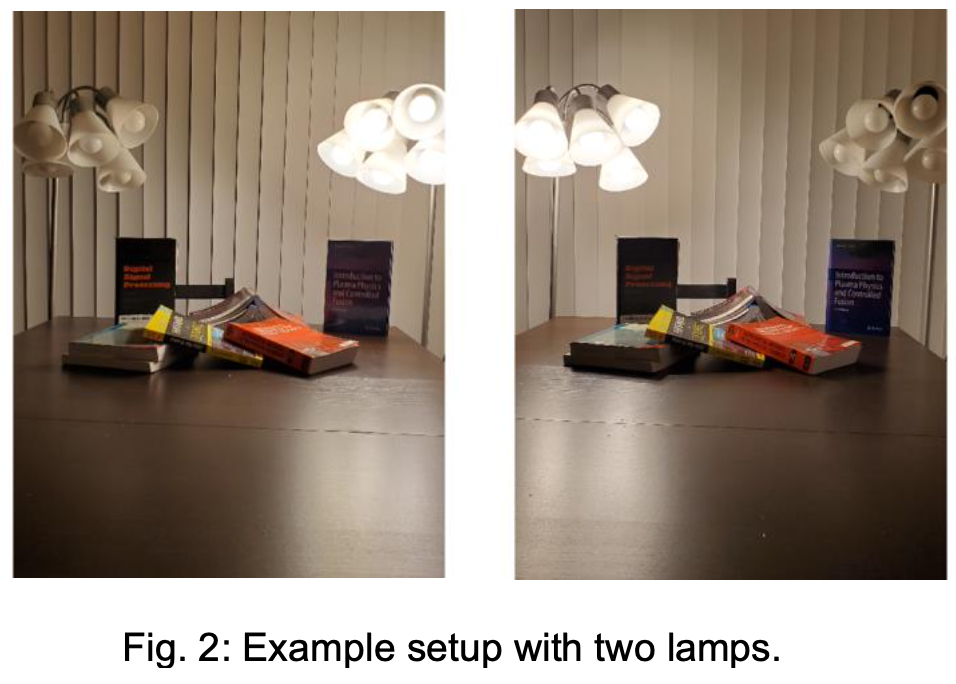

a. Capture the image of the scene by turning on LAMP1 only (image I1). Now capture an image by turning on LAMP2 only (image I2). Finally, capture the image with both LAMP1 and LAMP2 on (image I12). Load and display these images into your Colab notebook.

Image Lamp1 shape:  (3024, 4032, 3)


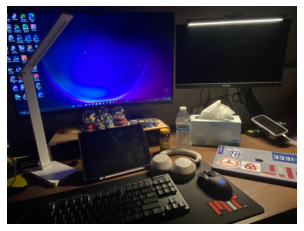

In [ ]:
I1 = Image.open('Lamp1.JPG')
I1 = np.array(I1)
print("Image Lamp1 shape: ", I1.shape)
plt.imshow(I1); plt.axis(False);

Image Lamp2 shape:  (3024, 4032, 3)


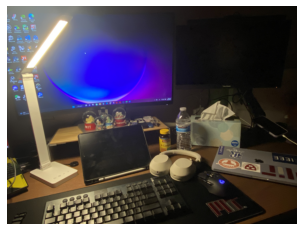

In [ ]:
I2 = Image.open('Lamp2.JPG')
I2 = np.array(I2)
print("Image Lamp2 shape: ", I2.shape)
plt.imshow(I2); plt.axis(False);

Image Lamp12 shape:  (3024, 4032, 3)


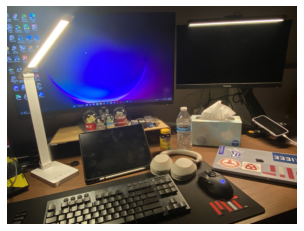

In [ ]:
I12 = Image.open('Lamp12.JPG')
I12 = np.array(I12)
print("Image Lamp12 shape: ", I12.shape)
plt.imshow(I12); plt.axis(False);

b. Now, you will create a synthetic photo (I12_synth) depicting the scene when both of the lamps are turned on by simply summing I1 and I2 together: I12_synth = I1 + I2. Also compute an image depicting the difference between the synthetic and real images: D = I12_synth - I12.

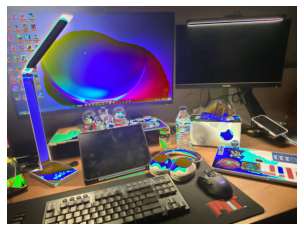

In [ ]:
I12_synth = I1 + I2
plt.imshow(I12_synth); plt.axis(False);

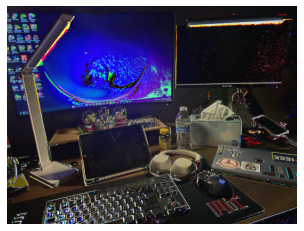

In [ ]:
D = I12_synth - I12
plt.imshow(D); plt.axis(False);

c. In your report, show I1, I2, I12, I12_synth, and D side by side. When displaying D, make sure to rescale D’s values to fill the full available dynamic range ([0,1] for float, or [0,255] for uint8). You can do this with the following operation: (D - min(D))/(max(D) - min(D)). 

<Figure size 432x288 with 0 Axes>

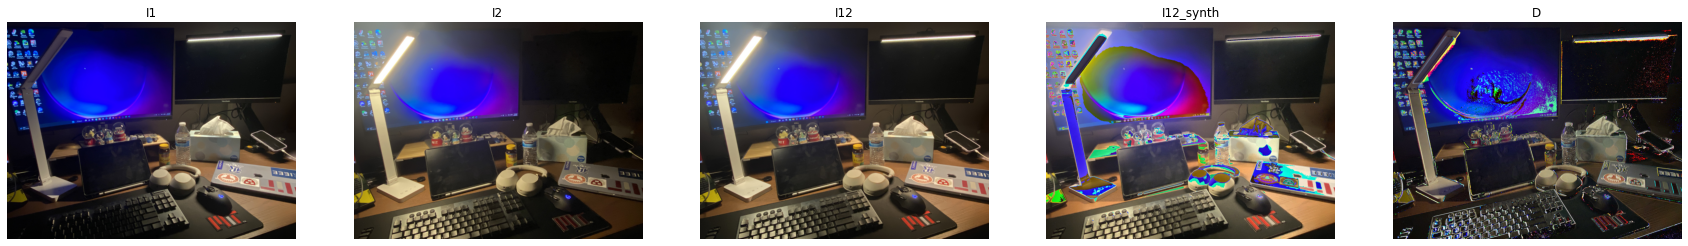

In [ ]:
if D.dtype == "float":
    D = (D - np.min(D)) / (np.max(D) - np.min(D))
else:
    D = np.uint8((D - np.min(D)) / (np.max(D) - np.min(D)) * 255)

plt.figure()
fig, ax = plt.subplots(1, 5, figsize=(30, 30)) 
output_images = [I1, I2, I12, I12_synth,D]
titles = ["I1", "I2", "I12", "I12_synth", "D"]
for i, img in enumerate(output_images):
    ax[i].imshow(img)
    ax[i].set_title(titles[i])
    ax[i].axis("off")